<div>
<img src="https://www.ul.ie/themes/custom/ul/logo.jpg" />
</div>

# **MSc in Artificial Intelligence and Machine Learning**
## CS6482 - Deep Reinforcement Learning
### Assignment 3: Sem2 AY 23/24 - DQN for Atari

Module Leader: J.J. Collins

Students:  
- Pratik Verma - 23007575
- Siddharth Prince - 23052058

---
## Code checks
| Sl. No. | Test case                             | Status |
|---------|---------------------------------------|--------|
| 1.      | [Imports and setup](#Imports-and-setup)  | <span style='color: #0e0'>Passed<span> |
| 2.      | [Data Pre-processing](#Data-pre-processing) | <span style='color: #0e0'>Passed</span> |
| 3.      | [Network structure and hyperparameters](#Network-structure-and-hyperparameters) | <span style='color: #0e0'>Passed</span> |
| 4.      | [Q-learning updates](#Q-learning-updates) | <span style='color: #0e0'>Passed</span> |
| 5.      | [Experimenting with Dueling DQN](#Experimenting-with-Dueling-DQN) | <span style='color: #0e0'>Passed</span> |
| 6.      | [Metrics and evalutation](#Metrics-and-evalutation) | <span style='color: #0e0'>Passed</span> |

## References
- [DQN Tutorial | Pytorch.org](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
- [Github: GiannisMitr/DQN-Atari-Breakout](https://github.com/GiannisMitr/DQN-Atari-Breakout/blob/master/dqn_atari_breakout.ipynb)
- [Github: KJ-Waller/DQN-PyTorch-Breakout](https://github.com/KJ-Waller/DQN-PyTorch-Breakout/blob/master/Breakout/DQN_model.py)
- [A Geron's Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow - Chapter 18 Reinforcement Learning sample notebook](https://github.com/ageron/handson-ml2/blob/8958d538bdcdf29d329d9950bfc79034c29db724/18_reinforcement_learning.ipynb)

## Imports and setup

In [15]:
import sys
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import rgb2gray

In [17]:
# Version checks
assert sys.version_info >= (3,10)

# to make this notebook's output stable across runs
SEED=42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [21]:
# Utility methods

# Method that plots the current state of the environment as an image
# Taken from Geron's ml2 RL example notebook
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    # returns an image of the environment as a Numpy array. 
    # 'rgb-array' mode does this instead of opening a separate window that renders the image.
    img = env.render(mode="rgb_array")
    plt.imshow(img) # shows the image as a plot via Matplotlib's pyplot module in the cell output
    plt.axis("off") # does not display the plot axes and just the image.
    return img

# Method sets the current frame to be plotted for the corresponding frame in the animation
# Taken from Geron's ml2 RL example notebook
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

# Method that plots an animation of the environment that cycles through each frame that corresponds to each step taken
# Taken from Geron's ml2 RL example notebook
def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')

    # uses matplotlib's animation module. The FuncAnimation method repeatedly calls a specified method for the number of 
    # provided frames. The specified function that is called, 'update_scene' is defined above.
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

We are choosing the _**`ALE/Breakout-v5`**_ gym environment because it simply has a good track record of being solved by DQNs. It was famously the first demonstration made by Google's DeepMind for a DQN agent. The full environment specification description is as follows:  
### ALE/Breakout-v5 Specification:
#### Description:
The below exceprt is taken from the [Gymnasium documentation](https://gymnasium.farama.org/environments/atari/breakout/) on the Breakout Atari environment.  
  
"The dynamics are similar to pong: You move a paddle and hit the ball in a brick wall at the top of the screen. Your goal is to destroy the brick wall. You can try to break through the wall and let the ball wreak havoc on the other side, all on its own! You have five lives."
#### Action Space:
- The action space is discrete.
- By default, all actions that can be performed on an Atari 2600 are available in this environment. These actions are:
|Value|Meaning|Value|Meaning|Value|Meaning|
|-----|-------|-----|-------|-----|-------|
|`0`|`NOOP`|`1`|`FIRE`|`2`|`UP`|
|`3`|`RIGHT`|`4`|`LEFT`|`5`|`DOWN`|
|`6`|`UPRIGHT`|`7`|`UPLEFT`|`8`|`DOWNRIGHT`|
|`9`|`DOWNLEFT`|`10`|`UPFIRE`|`11`|`RIGHTFIRE`|
|`12`|`LEFTFIRE`|`13`|`DOWNFIRE`|`14`|`UPRIGHTFIRE`|
|`15`|`UPLEFTFIRE`|`16`|`DOWNRIGHTFIRE`|`17`|`DOWNLEFTFIRE`|

- However, for the Breakout environment only 4 discrete actions from the above are meaningful. These are as follows:
 |Value|Meaning|Value|Meaning|Value|Meaning|
|-----|-------|-----|-------|-----|-------|
|`0`|`NOOP`|`1`|`FIRE`|`2`|`RIGHT`|
|`3`|`LEFT`|||||

- The above actions are self-explanatory with `LEFT` and `RIGHT` to move the paddle across the screen in the respective directions. `FIRE` is to serve a ball and get a round started. The player has 5 balls per game. `NOOP` is the usual no operation.
#### Observation Space:
- The observation space is an RGB image (colour image) with dimensions (210, 160, 3).
- Each pixel in the image represents a colour value (ranging from 0 to 255) for red, green, and blue channels.
- It can also be observed by the grayscale version of the image, which has dimensions (210, 160).
#### Rewards:
- Points are scored by destroying bricks in the wall.
- The reward for destroying a brick depends on the color of the brick. They are as follows as seen from the [Atariage documentation for Breakout](https://atariage.com/manual_html_page.php?SoftwareID=889).  
|Brick Colour|Points|Brick Colour|Points|Brick Colour|Points|
|------------|------|------------|------|------------|------|
|Red|7|Orange|7|Yellow|4|
|Green|4|Aqua|1|Blue|1|

#### Starting State:
The starting state of Breakout is with the paddle in the middle and 6 layers of bricks with blue being the lowest layer and red being the highest. Pressing `FIRE` serves the ball to get the game started.

#### Episode Termination/Objective:
The episode finishes if:
- If the ball goes out of bounds. Though there are 5 lives, losing one life terminates it ensure the agent learns to not loose lives.
- All the bricks in the wall are destroyed and the maximum score of `864` is reached.

In [18]:
# Set up the environment
env = gym.make("ALE/Breakout-v5", render_mode='rgb_array', obs_type="rgb")
obs = env.reset(seed=SEED) # initialising the environment with the reset() method 

In [19]:
env.action_space

Discrete(4)

## Data pre-processing

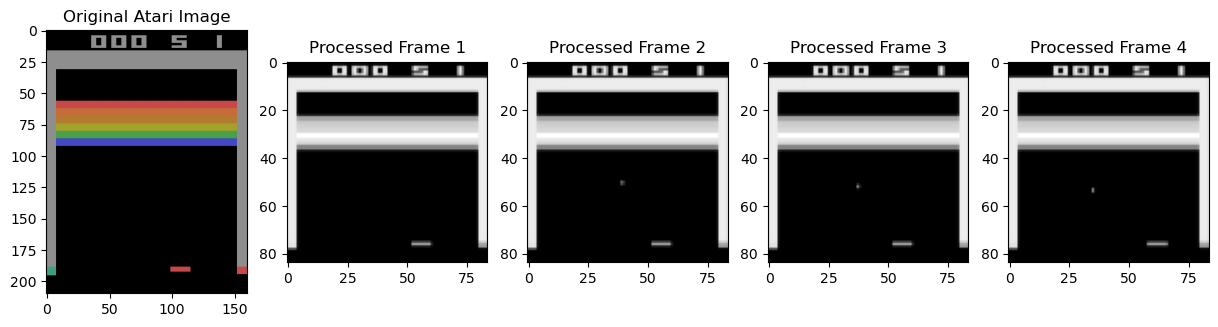

In [4]:
# Preprocess the observation
def preprocess_observation(obs):
    gray = rgb2gray(obs)
    resized = resize(gray, (84, 84), mode='constant')
    return np.uint8(resized * 255)

# Display an Atari image and the actual observation after processing
obs, _ = env.reset()
processed_obs = preprocess_observation(obs)
state = np.stack([processed_obs] * 4, axis=0)

# Simulate some steps to get varied frames
for _ in range(3):
    next_obs, _, _, _, _ = env.step(env.action_space.sample())
    processed_next_obs = preprocess_observation(next_obs)
    state = np.append(state[1:], np.expand_dims(processed_next_obs, 0), axis=0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 5, 1)
plt.imshow(obs)
plt.title('Original Atari Image')

for i in range(4):
    plt.subplot(1, 5, i + 2)
    plt.imshow(state[i], cmap='gray')
    plt.title(f'Processed Frame {i + 1}')

plt.show()

## Network structure and hyperparameters

In [12]:
# Hyperparameters
GAMMA = 0.99 # discount factor
EPSILON_START = 1.0 # rate of exploration set to all the time at the begininning of training
EPSILON_END = 0.1 # minimum probability with which the agent should choose to explore instead of exploite which is 10% of the time here
EPSILON_DECAY = 0.995 # The decay rate of epsilon
BATCH_SIZE = 32 # number of "experiences" (data) to be sampled during training
MEMORY_SIZE = 100000 # replay memory buffer size
TARGET_UPDATE = 10 # After how many steps is the target network's weights to be updated to the latest learnt by the policy netowrk
LR = 0.0001 # learning rate or alpha
NUM_EPISODES = 1000 # total number of training episodes. It is very low here in light of hardware and time limitations.

In [11]:
# Neural network for the DQN
class DQN(nn.Module):
    def __init__(self, action_space):
        super(DQN, self).__init__()
        # only 1 input channel since the image has been pre-processed to grayscale wtih 1 channel from RGB with 3 channels
        self.conv1 = nn.Conv2d(1, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 512) # Taking the flattened output feature maps from conv3
        self.fc2 = nn.Linear(512, action_space) # classifying possible Q values based for each action

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1) # Flattening the output of conv3 layer
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [6]:
# Replay buffer to store experiences
class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Function to select an action
def select_action(state, epsilon, action_space):
    if random.random() < epsilon:
        return random.randrange(action_space) # This is exploration where we just sample a random action index if a random value drawn is less than our epsilon (probability set for exploration here)
    else: # otherwise, we ask the agent to predict the next action based on what it has learnt so far i.e, exploitation.
        with torch.no_grad(): # puts it in testing mode where gradient calculation is disabled.
            state = torch.FloatTensor(state).unsqueeze(0).to(device) # Convert state numpy ndarray into a torch tensor loaded in GPU memory
            q_values = policy_net(state) # get the next Q value predictions from the model (agent) based on the current state corresponding to each action in the action space.
            return q_values.max(1)[1].item() # select the action that has the maximum Q value i.e, most optimal strategy

In [7]:
# Update the target network
def update_target(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())

# Training function
def optimize_model():
    if len(replay_buffer) < BATCH_SIZE:
        return

    batch = replay_buffer.sample(BATCH_SIZE)
    state_batch = torch.FloatTensor(np.array([b[0] for b in batch])).to(device)
    action_batch = torch.LongTensor(np.array([b[1] for b in batch])).to(device)
    reward_batch = torch.FloatTensor(np.array([b[2] for b in batch])).to(device)
    next_state_batch = torch.FloatTensor(np.array([b[3] for b in batch])).to(device)
    done_batch = torch.FloatTensor(np.array([b[4] for b in batch])).to(device)

    q_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)
    next_q_values = target_net(next_state_batch).max(1)[0]
    expected_q_values = reward_batch + (GAMMA * next_q_values * (1 - done_batch))

    loss = criterion(q_values, expected_q_values.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [8]:
# Initialize networks
action_space = env.action_space.n
input_shape = env.observation_space.shape
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # checking availability of the CUDA GPU compute
print(f"device: {device}")
policy_net = DQN(input_shape, action_space).to(device)
target_net = DQN(input_shape, action_space).to(device)
update_target(policy_net, target_net)

# Initialize optimizer and loss function
optimizer = optim.Adam(policy_net.parameters(), lr=LR) # Optimiser function of choice
criterion = nn.MSELoss() # loss function to calculate the loss between the target policy and the predicted policy values

# Initialize replay buffer
replay_buffer = ReplayBuffer(MEMORY_SIZE)

# Initialize epsilon and lists for tracking metrics
epsilon = EPSILON_START
mean_rewards_dqn = []
losses_dqn = []

# Print the model summary
summary(policy_net, (1, 84, 84))

device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 20, 20]           8,224
            Conv2d-2             [-1, 64, 9, 9]          32,832
            Conv2d-3             [-1, 64, 7, 7]          36,928
            Linear-4                  [-1, 512]       1,606,144
            Linear-5                    [-1, 4]           2,052
Total params: 1,686,180
Trainable params: 1,686,180
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.17
Params size (MB): 6.43
Estimated Total Size (MB): 6.71
----------------------------------------------------------------


## Q-learning updates

Episode 1/1000, Total Reward: 1.0, Epsilon: 0.995
Episode 2/1000, Total Reward: 2.0, Epsilon: 0.990
Episode 3/1000, Total Reward: 2.0, Epsilon: 0.985
Episode 4/1000, Total Reward: 0.0, Epsilon: 0.980
Episode 5/1000, Total Reward: 1.0, Epsilon: 0.975
Episode 6/1000, Total Reward: 0.0, Epsilon: 0.970
Episode 7/1000, Total Reward: 2.0, Epsilon: 0.966
Episode 8/1000, Total Reward: 0.0, Epsilon: 0.961
Episode 9/1000, Total Reward: 1.0, Epsilon: 0.956
Episode 10/1000, Total Reward: 0.0, Epsilon: 0.951
Episode 11/1000, Total Reward: 3.0, Epsilon: 0.946
Episode 12/1000, Total Reward: 1.0, Epsilon: 0.942
Episode 13/1000, Total Reward: 1.0, Epsilon: 0.937
Episode 14/1000, Total Reward: 2.0, Epsilon: 0.932
Episode 15/1000, Total Reward: 2.0, Epsilon: 0.928
Episode 16/1000, Total Reward: 0.0, Epsilon: 0.923
Episode 17/1000, Total Reward: 0.0, Epsilon: 0.918
Episode 18/1000, Total Reward: 1.0, Epsilon: 0.914
Episode 19/1000, Total Reward: 1.0, Epsilon: 0.909
Episode 20/1000, Total Reward: 1.0, Epsi

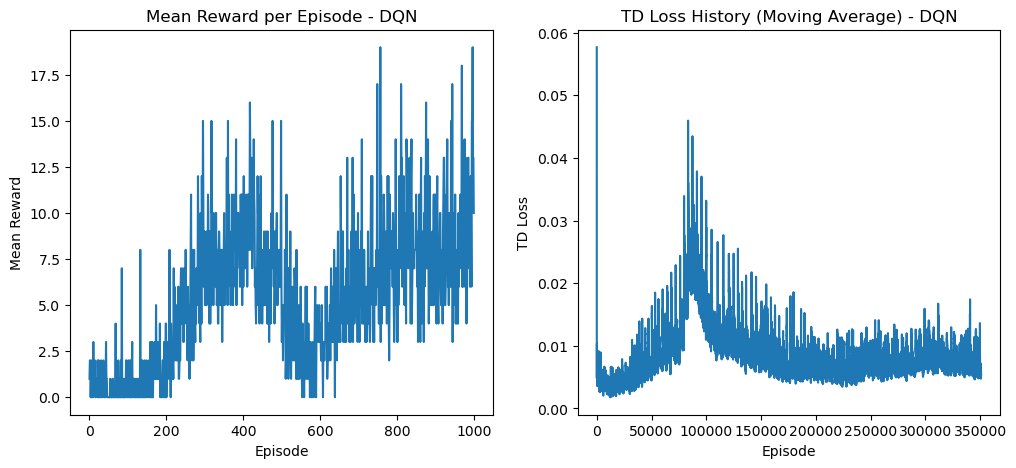

In [9]:
# Training loop
for episode in range(NUM_EPISODES):
    obs, _ = env.reset()
    state = preprocess_observation(obs)
    state = np.stack([state] * 4, axis=0)

    total_reward = 0
    done = False
    while not done:
        action = select_action(state, epsilon, action_space)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = preprocess_observation(next_obs)
        next_state = np.append(state[1:], np.expand_dims(next_state, 0), axis=0)

        replay_buffer.add((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        loss = optimize_model()
        if loss:
            losses_dqn.append(loss)

        if done:
            mean_rewards_dqn.append(total_reward)
            epsilon = max(EPSILON_END, EPSILON_DECAY * epsilon)
            print(f"Episode {episode+1}/{NUM_EPISODES}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    if (episode + 1) % TARGET_UPDATE == 0:
        update_target(policy_net, target_net)

# Plotting the mean rewards and TD loss history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(mean_rewards_dqn)
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.title('Mean Reward per Episode - DQN')

plt.subplot(1, 2, 2)
plt.plot(np.convolve(losses_dqn, np.ones(100)/100, mode='valid'))
plt.xlabel('Episode')
plt.ylabel('TD Loss')
plt.title('TD Loss History (Moving Average) - DQN')

plt.show()

## Experimenting with Dueling DQN

In [11]:
# Set up the environment
env = gym.make("ALE/Breakout-v5", render_mode='rgb_array', obs_type="rgb")


In [12]:
# Preprocess the observation
def preprocess_observation(obs):
    gray = rgb2gray(obs)
    resized = resize(gray, (84, 84), mode='constant')
    return np.uint8(resized * 255)


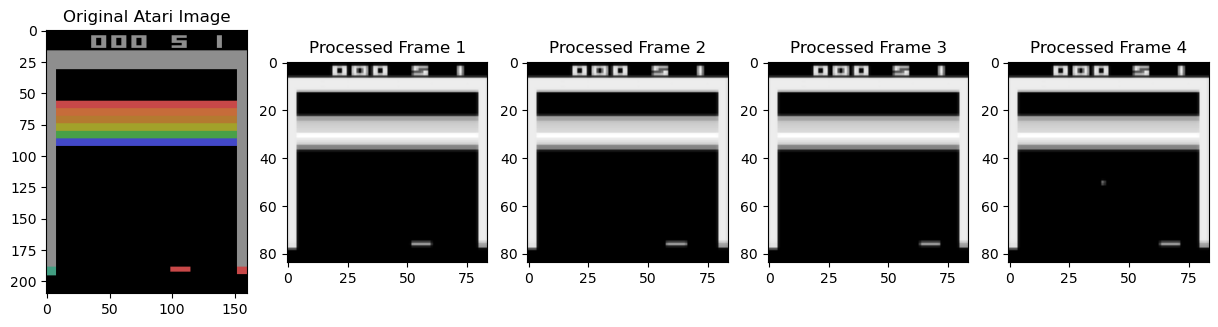

In [13]:
# Display an Atari image and the actual observation after processing
obs, _ = env.reset()
processed_obs = preprocess_observation(obs)
state = np.stack([processed_obs] * 4, axis=0)

# Simulate some steps to get varied frames
for _ in range(3):
    next_obs, _, _, _, _ = env.step(env.action_space.sample())
    processed_next_obs = preprocess_observation(next_obs)
    state = np.append(state[1:], np.expand_dims(processed_next_obs, 0), axis=0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 5, 1)
plt.imshow(obs)
plt.title('Original Atari Image')

for i in range(4):
    plt.subplot(1, 5, i + 2)
    plt.imshow(state[i], cmap='gray')
    plt.title(f'Processed Frame {i + 1}')

plt.show()

In [10]:
# Hyperparameters
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 0.995
BATCH_SIZE = 32
MEMORY_SIZE = 100000
TARGET_UPDATE = 10
LR = 0.0001
NUM_EPISODES = 1000

In [14]:
# Neural network for the Dueling DQN
class DuelingDQN(nn.Module):
    def __init__(self, action_space):
        super(DuelingDQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.value_stream = nn.Linear(512, 1)
        self.advantage_stream = nn.Linear(512, action_space)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))

        # this estimates the value of the current state i.e., how valuable it is for the agent to be in the current state to achieve the reward.
        value = self.value_stream(x) # Outputs the single value as can be seen from this layer's definition where it has only one output.
        advantage = self.advantage_stream(x) # this estimates the advantage for each action in the action space as usual just like in the previous DQN architecture.
        
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True)) # value and advantage is combined with this formula to get the final Q value output.
        return q_values

In [15]:
# Replay buffer to store experiences
class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Function to select an action
def select_action(state, epsilon, action_space):
    if random.random() < epsilon:
        return random.randrange(action_space)
    else:
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = policy_net(state)
            return q_values.max(1)[1].item()

In [16]:
# Update the target network
def update_target(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())

# Training function
def optimize_model():
    if len(replay_buffer) < BATCH_SIZE:
        return

    batch = replay_buffer.sample(BATCH_SIZE)
    state_batch = torch.FloatTensor(np.array([b[0] for b in batch])).to(device)
    action_batch = torch.LongTensor(np.array([b[1] for b in batch])).to(device)
    reward_batch = torch.FloatTensor(np.array([b[2] for b in batch])).to(device)
    next_state_batch = torch.FloatTensor(np.array([b[3] for b in batch])).to(device)
    done_batch = torch.FloatTensor(np.array([b[4] for b in batch])).to(device)

    q_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)
    next_q_values = target_net(next_state_batch).max(1)[0]
    expected_q_values = reward_batch + (GAMMA * next_q_values * (1 - done_batch))

    loss = criterion(q_values, expected_q_values.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [17]:
# Initialize networks for Dueling DQN
policy_net = DuelingDQN(action_space).to(device)
target_net = DuelingDQN(action_space).to(device)
update_target(policy_net, target_net)

# Initialize optimizer and loss function for Dueling DQN
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
criterion = nn.MSELoss()

# Initialize replay buffer for Dueling DQN
replay_buffer = ReplayBuffer(MEMORY_SIZE)

# Initialize epsilon and lists for tracking metrics for Dueling DQN
epsilon = EPSILON_START
mean_rewards_dueling_dqn = []
losses_dueling_dqn = []

# Print the model summary
summary(policy_net, (4, 84, 84))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 20, 20]           8,224
            Conv2d-2             [-1, 64, 9, 9]          32,832
            Conv2d-3             [-1, 64, 7, 7]          36,928
            Linear-4                  [-1, 512]       1,606,144
            Linear-5                    [-1, 1]             513
            Linear-6                    [-1, 4]           2,052
Total params: 1,686,693
Trainable params: 1,686,693
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.17
Params size (MB): 6.43
Estimated Total Size (MB): 6.71
----------------------------------------------------------------


Dueling DQN Episode 1/1000, Total Reward: 1.0, Epsilon: 0.995
Dueling DQN Episode 2/1000, Total Reward: 2.0, Epsilon: 0.990
Dueling DQN Episode 3/1000, Total Reward: 3.0, Epsilon: 0.985
Dueling DQN Episode 4/1000, Total Reward: 3.0, Epsilon: 0.980
Dueling DQN Episode 5/1000, Total Reward: 2.0, Epsilon: 0.975
Dueling DQN Episode 6/1000, Total Reward: 1.0, Epsilon: 0.970
Dueling DQN Episode 7/1000, Total Reward: 0.0, Epsilon: 0.966
Dueling DQN Episode 8/1000, Total Reward: 1.0, Epsilon: 0.961
Dueling DQN Episode 9/1000, Total Reward: 0.0, Epsilon: 0.956
Dueling DQN Episode 10/1000, Total Reward: 1.0, Epsilon: 0.951
Dueling DQN Episode 11/1000, Total Reward: 0.0, Epsilon: 0.946
Dueling DQN Episode 12/1000, Total Reward: 3.0, Epsilon: 0.942
Dueling DQN Episode 13/1000, Total Reward: 1.0, Epsilon: 0.937
Dueling DQN Episode 14/1000, Total Reward: 0.0, Epsilon: 0.932
Dueling DQN Episode 15/1000, Total Reward: 3.0, Epsilon: 0.928
Dueling DQN Episode 16/1000, Total Reward: 0.0, Epsilon: 0.923
D

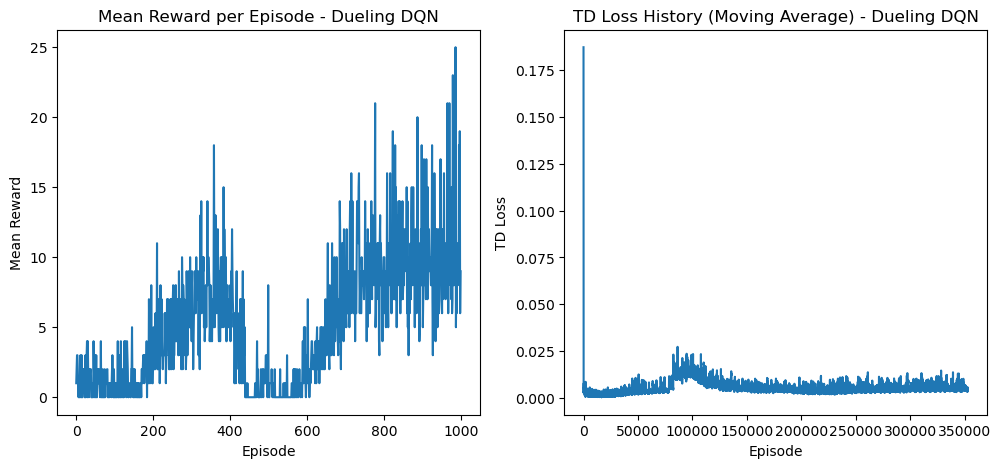

In [18]:
# Training loop for Dueling DQN
for episode in range(NUM_EPISODES):
    obs, _ = env.reset()
    state = preprocess_observation(obs)
    state = np.stack([state] * 4, axis=0)

    total_reward = 0
    done = False
    while not done:
        action = select_action(state, epsilon, action_space)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = preprocess_observation(next_obs)
        next_state = np.append(state[1:], np.expand_dims(next_state, 0), axis=0)

        replay_buffer.add((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        loss = optimize_model()
        if loss:
            losses_dueling_dqn.append(loss)

        if done:
            mean_rewards_dueling_dqn.append(total_reward)
            epsilon = max(EPSILON_END, EPSILON_DECAY * epsilon)
            print(f"Dueling DQN Episode {episode+1}/{NUM_EPISODES}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    if (episode + 1) % TARGET_UPDATE == 0:
        update_target(policy_net, target_net)



# Plotting the mean rewards and TD loss history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(mean_rewards_dueling_dqn)
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.title('Mean Reward per Episode - Dueling DQN')

plt.subplot(1, 2, 2)
plt.plot(np.convolve(losses_dueling_dqn, np.ones(100)/100, mode='valid'))
plt.xlabel('Episode')
plt.ylabel('TD Loss')
plt.title('TD Loss History (Moving Average) - Dueling DQN')

plt.show()



## Metrics and evalutation

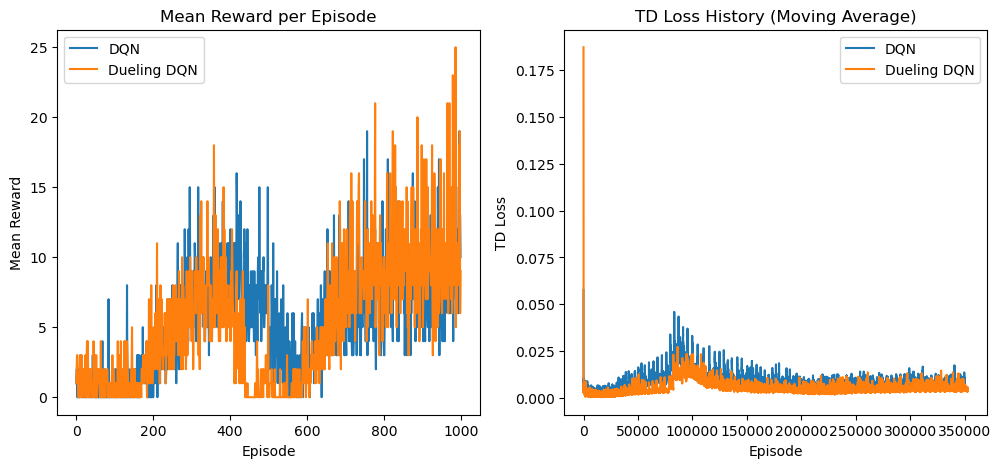

In [19]:

# Plotting the mean rewards and TD loss history for both DQN and Dueling DQN
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mean_rewards_dqn, label='DQN')
plt.plot(mean_rewards_dueling_dqn, label='Dueling DQN')
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.title('Mean Reward per Episode')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.convolve(losses_dqn, np.ones(100)/100, mode='valid'), label='DQN')
plt.plot(np.convolve(losses_dueling_dqn, np.ones(100)/100, mode='valid'), label='Dueling DQN')
plt.xlabel('Episode')
plt.ylabel('TD Loss')
plt.title('TD Loss History (Moving Average)')
plt.legend()

plt.show()